<a href="https://colab.research.google.com/github/allen44/riiid-test-answer-prediction/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make Train Test Splits

In [ ]:
# define target variable, y, and independant variables, X

X = df.drop(columns=['answered_correctly'])
y = df['answered_correctly']

X.shape, y.shape


((10124, 9), (10124,))

In [ ]:
# Make Train Test Splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8099, 9), (2025, 9), (8099,), (2025,))

#Transform data to fit classifier

Some classifier require variables in a certian form. Some classifiers cannot handle NA values. We will fix those in this section.


In [ ]:
# Count NA values
X_train.isna().sum()

timestamp                           0
user_id                             0
content_id                          0
content_type_id                     0
task_container_id                   0
user_answer                         0
prior_question_elapsed_time       173
prior_question_had_explanation      0
user_id_event_count                 0
dtype: int64

Even though most data is not NA, recall that the data description showed that some data is "null" but were encoded as '-1' or other values. We'll encode them as NA instead.

In [ ]:
# Convert Null values to NA

encoded_X = X.copy()
print('Before:\n', encoded_X.isna().sum())

# content_type_id: "1 if the event was the user watching a lecture."
encoded_X['content_type_id'] = encoded_X['content_type_id'].mask(encoded_X['content_type_id']==1)


# user_answer: " Read -1 as null, for lectures."
encoded_X['user_answer'] = encoded_X['user_answer'].mask(encoded_X['user_answer']==-1)

# # answered_correctly Read -1 as null, for lectures
# encoded_X['answered_correctly'] = encoded_X['answered_correctly'].mask(encoded_X['answered_correctly']==-1)


# Count the NA entries
print('\nAfter:\n', encoded_X.isna().sum())

Before:
 timestamp                           0
user_id                             0
content_id                          0
content_type_id                     0
task_container_id                   0
user_answer                         0
prior_question_elapsed_time       222
prior_question_had_explanation      0
user_id_event_count                 0
dtype: int64

After:
 timestamp                           0
user_id                             0
content_id                          0
content_type_id                   201
task_container_id                   0
user_answer                       201
prior_question_elapsed_time       222
prior_question_had_explanation      0
user_id_event_count                 0
dtype: int64


In the before and after printouts, we see the effect of masking the null-encoded values, and replacing them with NA.

## Drop NA rows 

Based on our earlier EDA, we have enough information to make informed decision on how to handle NA values.



In [ ]:
encoded_X.shape

(10124, 9)

In [ ]:
encoded_X_no_na = encoded_X.dropna().reset_index(drop=True)
encoded_X_no_na.isna().sum()

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_id_event_count               0
dtype: int64

In [ ]:
encoded_X_no_na.shape

(9902, 9)

We see that the .shape attribute shows that about 2% of the entries were dropped.

## Drop features that don't predict the target variable

In [ ]:
# Drop user_id
encoded_X_no_na = encoded_X_no_na.drop(columns='user_id').reset_index(drop=True)
encoded_X_no_na

,timestamp,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,user_id_event_count
0,2868613211,1219,0,780,1,17000.0,True,1
1,14686539127,10656,0,1317,0,19000.0,True,1
2,1083486476,6857,0,243,3,11750.0,True,1
3,15426935577,6798,0,1515,0,9000.0,False,1
4,8841108363,10294,0,988,2,31500.0,True,1
...,...,...,...,...,...,...,...,...
9897,1158534297,383,0,300,0,20000.0,True,1
9898,9269436738,11859,0,163,1,26000.0,True,1
9899,4609471378,1202,0,1506,1,15000.0,True,1
9900,689004,6880,0,14,2,44000.0,False,1


## Encode Dummy Variables

The categorical variables need to be one-hot-encoded for most of the models to work correctly.

The numerical variables may need to be standardized for some models.


In [ ]:
# X_t = pd.get_dummies(X, drop_first=False, dtype=bool)
X_t = pd.get_dummies(X, drop_first=True, dtype=bool)
X_t

,timestamp,prior_question_elapsed_time,prior_question_had_explanation,user_id_event_count,user_id_91216,user_id_220268,user_id_650467,user_id_1084314,user_id_1282581,user_id_1283420,user_id_1502650,user_id_1765772,user_id_1989232,user_id_2078569,user_id_2393889,user_id_2475583,user_id_2678068,user_id_2891629,user_id_3194563,user_id_3270696,user_id_3637398,user_id_3824269,user_id_3892809,user_id_4022163,user_id_4222121,user_id_4324252,user_id_4421282,user_id_4498487,user_id_4702585,user_id_4877689,user_id_5103696,user_id_5365886,user_id_5401739,user_id_5615405,user_id_5986081,user_id_6146089,user_id_6475477,user_id_6610089,user_id_6812883,user_id_7051394,...,task_container_id_8328,task_container_id_8340,task_container_id_8461,task_container_id_8544,task_container_id_8600,task_container_id_8615,task_container_id_8689,task_container_id_8735,task_container_id_8769,task_container_id_8852,task_container_id_8867,task_container_id_8891,task_container_id_8914,task_container_id_8972,task_container_id_8993,task_container_id_9024,task_container_id_9076,task_container_id_9080,task_container_id_9145,task_container_id_9148,task_container_id_9157,task_container_id_9181,task_container_id_9187,task_container_id_9218,task_container_id_9229,task_container_id_9276,task_container_id_9289,task_container_id_9308,task_container_id_9458,task_container_id_9471,task_container_id_9695,task_container_id_9703,task_container_id_9742,task_container_id_9936,task_container_id_9953,task_container_id_9975,user_answer_0,user_answer_1,user_answer_2,user_answer_3
0,0,NaN,True,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2868613211,17000.0,True,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,14686539127,19000.0,True,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,1083486476,11750.0,True,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,15426935577,9000.0,False,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,..

We see the row count is unchanged, but now there's many more columns due to how we changed all the categorical data into numerical data.

In [ ]:
X_t.shape

(10124, 18270)

###Alternatively, encode with skllearn OneHotEncoder


In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_train_cat = encoded_X_no_na.select_dtypes(['category', 'bool'])
X_train_num = encoded_X_no_na.select_dtypes(['int64', 'float64'])

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore")

# Fit on X_train_cat and then Transform X_train_cat
X_train_cat = encoder.fit_transform(X_train_cat)
X_train_cat.shape

(9902, 8071)

<5x8071 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

### Standardize the numerical variables.



In [ ]:
# Check for normality on numerical features
from scipy.stats import kstest

X_num = X.select_dtypes(exclude=['category', 'bool'])
numerical_columns = X_num.columns

for feature in X_num.columns:
  statistic, p = kstest(X_num[feature], 'norm')
  print(f"\n{feature}:\nStatistic: {statistic:0.5f}, p_value: {p:0.5f}")
  print('Probably gaussian.') if p>0.05 else print('Probably not gaussian.') 


timestamp:
Statistic: 0.99793, p_value: 0.00000
Probably not gaussian.

prior_question_elapsed_time:
Statistic: nan, p_value: nan
Probably not gaussian.

user_id_event_count:
Statistic: 0.84134, p_value: 0.00000
Probably not gaussian.


We see that none of the numerical features are normally distributed. Let's standardize them using the StandardScaler.

In [ ]:
from sklearn.preprocessing import StandardScaler
 
# Instantiate scaler object
scaler = StandardScaler()

# Fit: Compute the mean and std to be used for later scaling.
# And tranform
X_new = scaler.fit_transform(X_num)
X_new

array([[-0.41411096, -0.42315151, -0.11578869],
       [ 0.61734447, -0.32505444, -0.11578869],
       [-0.56991483, -0.68065633, -0.11578869],
       ...,
       [-0.26217079, -0.52124859, -0.11578869],
       [-0.66442019,  0.90115899, -0.11578869],
       [-0.66441337, -0.52124859, -0.11578869]])

In [ ]:
# Check the old vs new mean
np.mean(X_num, axis=0), np.mean(X_new, axis=0)

(timestamp                      7.613300e+09
 prior_question_elapsed_time    2.562720e+04
 user_id_event_count            1.013230e+00
 dtype: float64, array([ 2.47563365e-17,  8.53914215e-17, -4.23369233e-17]))

In [ ]:
# Check the old vs new standard deviation
np.std(X_num, axis=0), np.std(X_new, axis=0)

(timestamp                      1.145752e+10
 prior_question_elapsed_time    2.038797e+04
 user_id_event_count            1.142568e-01
 dtype: float64, array([1., 1., 1.]))

As expected, the X_new means are zero, and the standard deviations are 1.

### Combine the transformed features into one transformed dataframe.

In [ ]:
#Make sure the shapes are compatible
X_t.shape, X_new.shape


((9902, 8214), (9902, 3))

In [ ]:
# Check index on X_t
X_t.index

RangeIndex(start=0, stop=9902, step=1)

In [ ]:
# Make a dataframe for X_new
X_new_df = pd.DataFrame(X_new, columns=numerical_columns)
X_new_df

,timestamp,prior_question_elapsed_time,user_id_event_count
0,-0.414111,-0.423152,-0.115789
1,0.617344,-0.325054,-0.115789
2,-0.569915,-0.680656,-0.115789
3,0.681965,-0.815540,-0.115789
4,0.107162,0.288052,-0.115789
...,...,...,...
9897,-0.563365,-0.276006,-0.115789
9898,0.144546,0.018285,-0.115789
9899,-0.262171,-0.521249,-0.115789
9900,-0.664420,0.901159,-0.115789


In [ ]:
X_new_df.isna().sum()

timestamp                      0
prior_question_elapsed_time    0
user_id_event_count            0
dtype: int64

In [ ]:
X_new_df.dtypes

timestamp                      float64
prior_question_elapsed_time    float64
user_id_event_count            float64
dtype: object

In [ ]:
X_t[numerical_columns].dtypes

timestamp                        int64
prior_question_elapsed_time    float64
user_id_event_count              int64
dtype: object

In [ ]:
# Select all numerical columns from X_new

numerical_columns = X_new_df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['timestamp', 'prior_question_elapsed_time', 'user_id_event_count'], dtype='object')

In [ ]:
# Add transformed numerical columns
for num_feature in numerical_columns:
  X_t[num_feature] = X_new_df[num_feature]
X_t[numerical_columns]

,timestamp,prior_question_elapsed_time,user_id_event_count
0,-0.414111,-0.423152,-0.115789
1,0.617344,-0.325054,-0.115789
2,-0.569915,-0.680656,-0.115789
3,0.681965,-0.815540,-0.115789
4,0.107162,0.288052,-0.115789
...,...,...,...
9897,-0.563365,-0.276006,-0.115789
9898,0.144546,0.018285,-0.115789
9899,-0.262171,-0.521249,-0.115789
9900,-0.664420,0.901159,-0.115789


In [ ]:
X_t.dtypes

timestamp                         float64
prior_question_elapsed_time       float64
prior_question_had_explanation       bool
user_id_event_count               float64
content_id_1                         bool
                                   ...   
task_container_id_9975               bool
user_answer_0                        bool
user_answer_1                        bool
user_answer_2                        bool
user_answer_3                        bool
Length: 8214, dtype: object

In [ ]:
X_t.shape

(9902, 8214)

# Baseline Modelling

## Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training roc_auc_score: 0.95133
Testing roc_auc_score: 0.56963


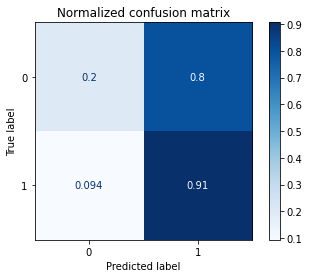

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

# Instantiate classifier object
log_reg = LogisticRegression()

# Fit classifier
log_reg.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = log_reg.predict_proba(X_train)[:,1]
y_test_preds = log_reg.predict_proba(X_test)[:,1]

#Score the predictions
log_reg_train_roc_score = roc_auc_score(y_train, y_train_preds)
log_reg_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {log_reg_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {log_reg_test_roc_score:0.5f}")

# Plot normalized confusion matrix
disp = plot_confusion_matrix(log_reg, X_test, y_test,
                              cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

That's a pretty bad score for a baseline model. It's good in training, and terrible in test.


## LightGBM

Training roc_auc_score: 0.56285
Testing roc_auc_score: 0.52845


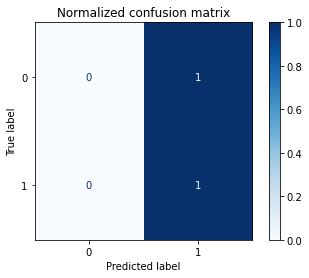

In [ ]:
from lightgbm import LGBMClassifier

# Instantiate the classifier object
lgbm = LGBMClassifier(
    num_leaves=31, 
    max_depth= 2, 
    n_estimators = 25, 
    min_child_samples = 1000, 
    subsample=0.7, 
    subsample_freq=5,
    n_jobs= -1,
    is_higher_better = True,
    first_metric_only = True
)

# Fit the classifier object to the train data
lgbm.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = lgbm.predict_proba(X_train)[:,1]
y_test_preds = lgbm.predict_proba(X_test)[:,1]

#Score the predictions
lgbm_train_roc_score = roc_auc_score(y_train, y_train_preds)
lgbm_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {lgbm_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {lgbm_test_roc_score:0.5f}")

# Plot normalized confusion matrix
disp = plot_confusion_matrix(lgbm, X_test, y_test,
                              cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

We see that the LGBM baseline is better than the logistic regression model baseline.

## K-Nearest-Neighbors Classifier

Training roc_auc_score: 0.89008
Testing roc_auc_score: 0.63538


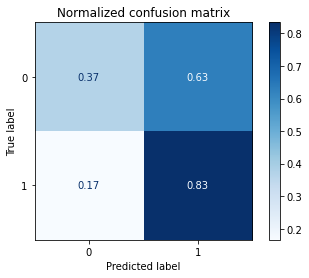

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the classifier object
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier object to the train data
knn.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_preds = knn.predict_proba(X_train)[:,1]
y_test_preds = knn.predict_proba(X_test)[:,1]

#Score the predictions
knn_train_roc_score = roc_auc_score(y_train, y_train_preds)
knn_test_roc_score = roc_auc_score(y_test, y_test_preds)

print(f"Training roc_auc_score: {knn_train_roc_score:0.5f}")
print(f"Testing roc_auc_score: {knn_test_roc_score:0.5f}")

# Plot normalized confusion matrix
disp = plot_confusion_matrix(knn, X_test, y_test,
                              cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
plt.show()

## Section Summary

We tested three baseline models: Logistic Regression, LightGBM, and K-Nearest Neighbors. Each model is from a different class of models and they each have their trade-offs and assumptions.

Logistic Regression performed well intraining and poorly in testing.

K-Nearest-Neighbors performed great in training but worst of all three models on the test data. This is evidence that the model baseline tuning is over-fitting on noise in the training data.

LightGBM performed the worst with the baseline hyperparameters. It assigned the target variable the same value for all inputs. It did not learn anything from training. I'll have to adjust the code on this model.



We see that the baseline K-Nearest-Neighbors Classifier did quite well on the training set, but very poorly on the test set. KNN takes the longest to run. I'll have to adjust the hyper parameters or do some feature engineering to reduce the number of columns. Also, as the KNN took about 20 times longer to run than the other models, it makes sense that it's mch better.


In [ ]:
#Training and test roc_scores
print(f"log_reg_train_roc_score: {log_reg_train_roc_score:0.5f}")
print(f"log_reg_test_roc_score: {log_reg_test_roc_score:0.5f}")

print(f"lgbm_train_roc_score: {lgbm_train_roc_score:0.5f}")
print(f"lgbm_test_roc_score: {lgbm_test_roc_score:0.5f}")

print(f"knn_train_roc_score: {knn_train_roc_score:0.5f}")
print(f"knn_test_roc_score: {knn_test_roc_score:0.5f}")

log_reg_train_roc_score: 0.95133
log_reg_test_roc_score: 0.56963
lgbm_train_roc_score: 0.56285
lgbm_test_roc_score: 0.52845
knn_train_roc_score: 0.89008
knn_test_roc_score: 0.63538
